In [0]:
import numpy as np
import pandas as pd

from __future__ import print_function, division

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from PIL import Image
import copy
import time


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#SaveSave file to google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
torch.manual_seed(42)

In [0]:
# settings
img_size = 28
channels = 1
num_classes = 5

# model parameters
batch_size = 64
learning_rate = 1e-4
EPOCHS = 20

# training parameters
device='cuda'

In [0]:
# load data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/testX.csv')

print("train data \n", len(train), "\n", train.head())
print("test data \n", len(test), "\n", test.head())

train data 
 60000 
       Id  Label  1  2  3  4  5  6  ...  777  778  779  780  781  782  783  784
0  10000      4  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
1  10001      0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
2  10002      0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
3  10003      4  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
4  10004      1  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0

[5 rows x 786 columns]
test data 
 10000 
    Id  0  1  2  3  4  5  6  7  ...  775  776  777  778  779  780  781  782  783
0   0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
1   1  0  0  0  0  0  1  0  0  ...  114  130   76    0    0    0    0    0    0
2   2  0  0  0  0  0  0  0  0  ...    0    1    0    0    0    0    0    0    0
3   3  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
4   4  0  0  0  0  0  0  0  0  ...    0    0    0    0    0  

In [0]:
# process input data
# drop the label and id column in the dataframe
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

test = test.values
test = test.reshape(-1, img_size, img_size, channels).astype(np.uint8)
print("Test data shape: ", test.shape)

# get the data label
y = train['Label'].values
X = train.drop('Label', axis=1).values

Test data shape:  (10000, 28, 28, 1)


In [0]:
# split training data to train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# convert it to image
X_train = X_train.reshape(-1, img_size, img_size, channels).astype(np.uint8)
X_test = X_test.reshape(-1, img_size, img_size, channels).astype(np.uint8)

print("training set size: ", X_train.shape)
print("validation set size: ",X_test.shape)



training set size:  (48000, 28, 28, 1)
validation set size:  (12000, 28, 28, 1)


In [0]:
class MNFDataset(Dataset):
    """ Parse data
    """
    def __init__(self, arrays, transform=None):
      self.arrays = arrays
      self.transform = transform

    def __len__(self):
      return self.arrays[0].shape[0]

    def __getitem__(self, index):
      # get the numpy array
      x = self.arrays[0][index]
      # get the label
      y = self.arrays[1][index]

      if self.transform:
          x = self.transform(x)


      return x, y

In [0]:
# perform data preprocessing and augmentation
# horizontal flip tensor
_TR_transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Grayscale(num_output_channels=3),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
])

_VL_transform = transforms.Compose([                    
              transforms.ToPILImage(),
              transforms.Grayscale(num_output_channels=3),
              transforms.ToTensor(),
])

# create the train and validation dataset
# train_dst = torch.utils.data.TensorDataset(_X_train, _y_train)
# valid_dst = torch.utils.data.TensorDataset(_X_test, _y_test)
train_dst = MNFDataset(arrays=(X_train, y_train), transform=_TR_transform)
valid_dst = MNFDataset(arrays=(X_test, y_test), transform=_VL_transform)

print("train set size: ", len(train_dst))
print("valid set size: ", len(valid_dst))

# create data loader
train_loader = torch.utils.data.DataLoader(train_dst, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dst, batch_size=batch_size, shuffle=True)


train set size:  48000
valid set size:  12000


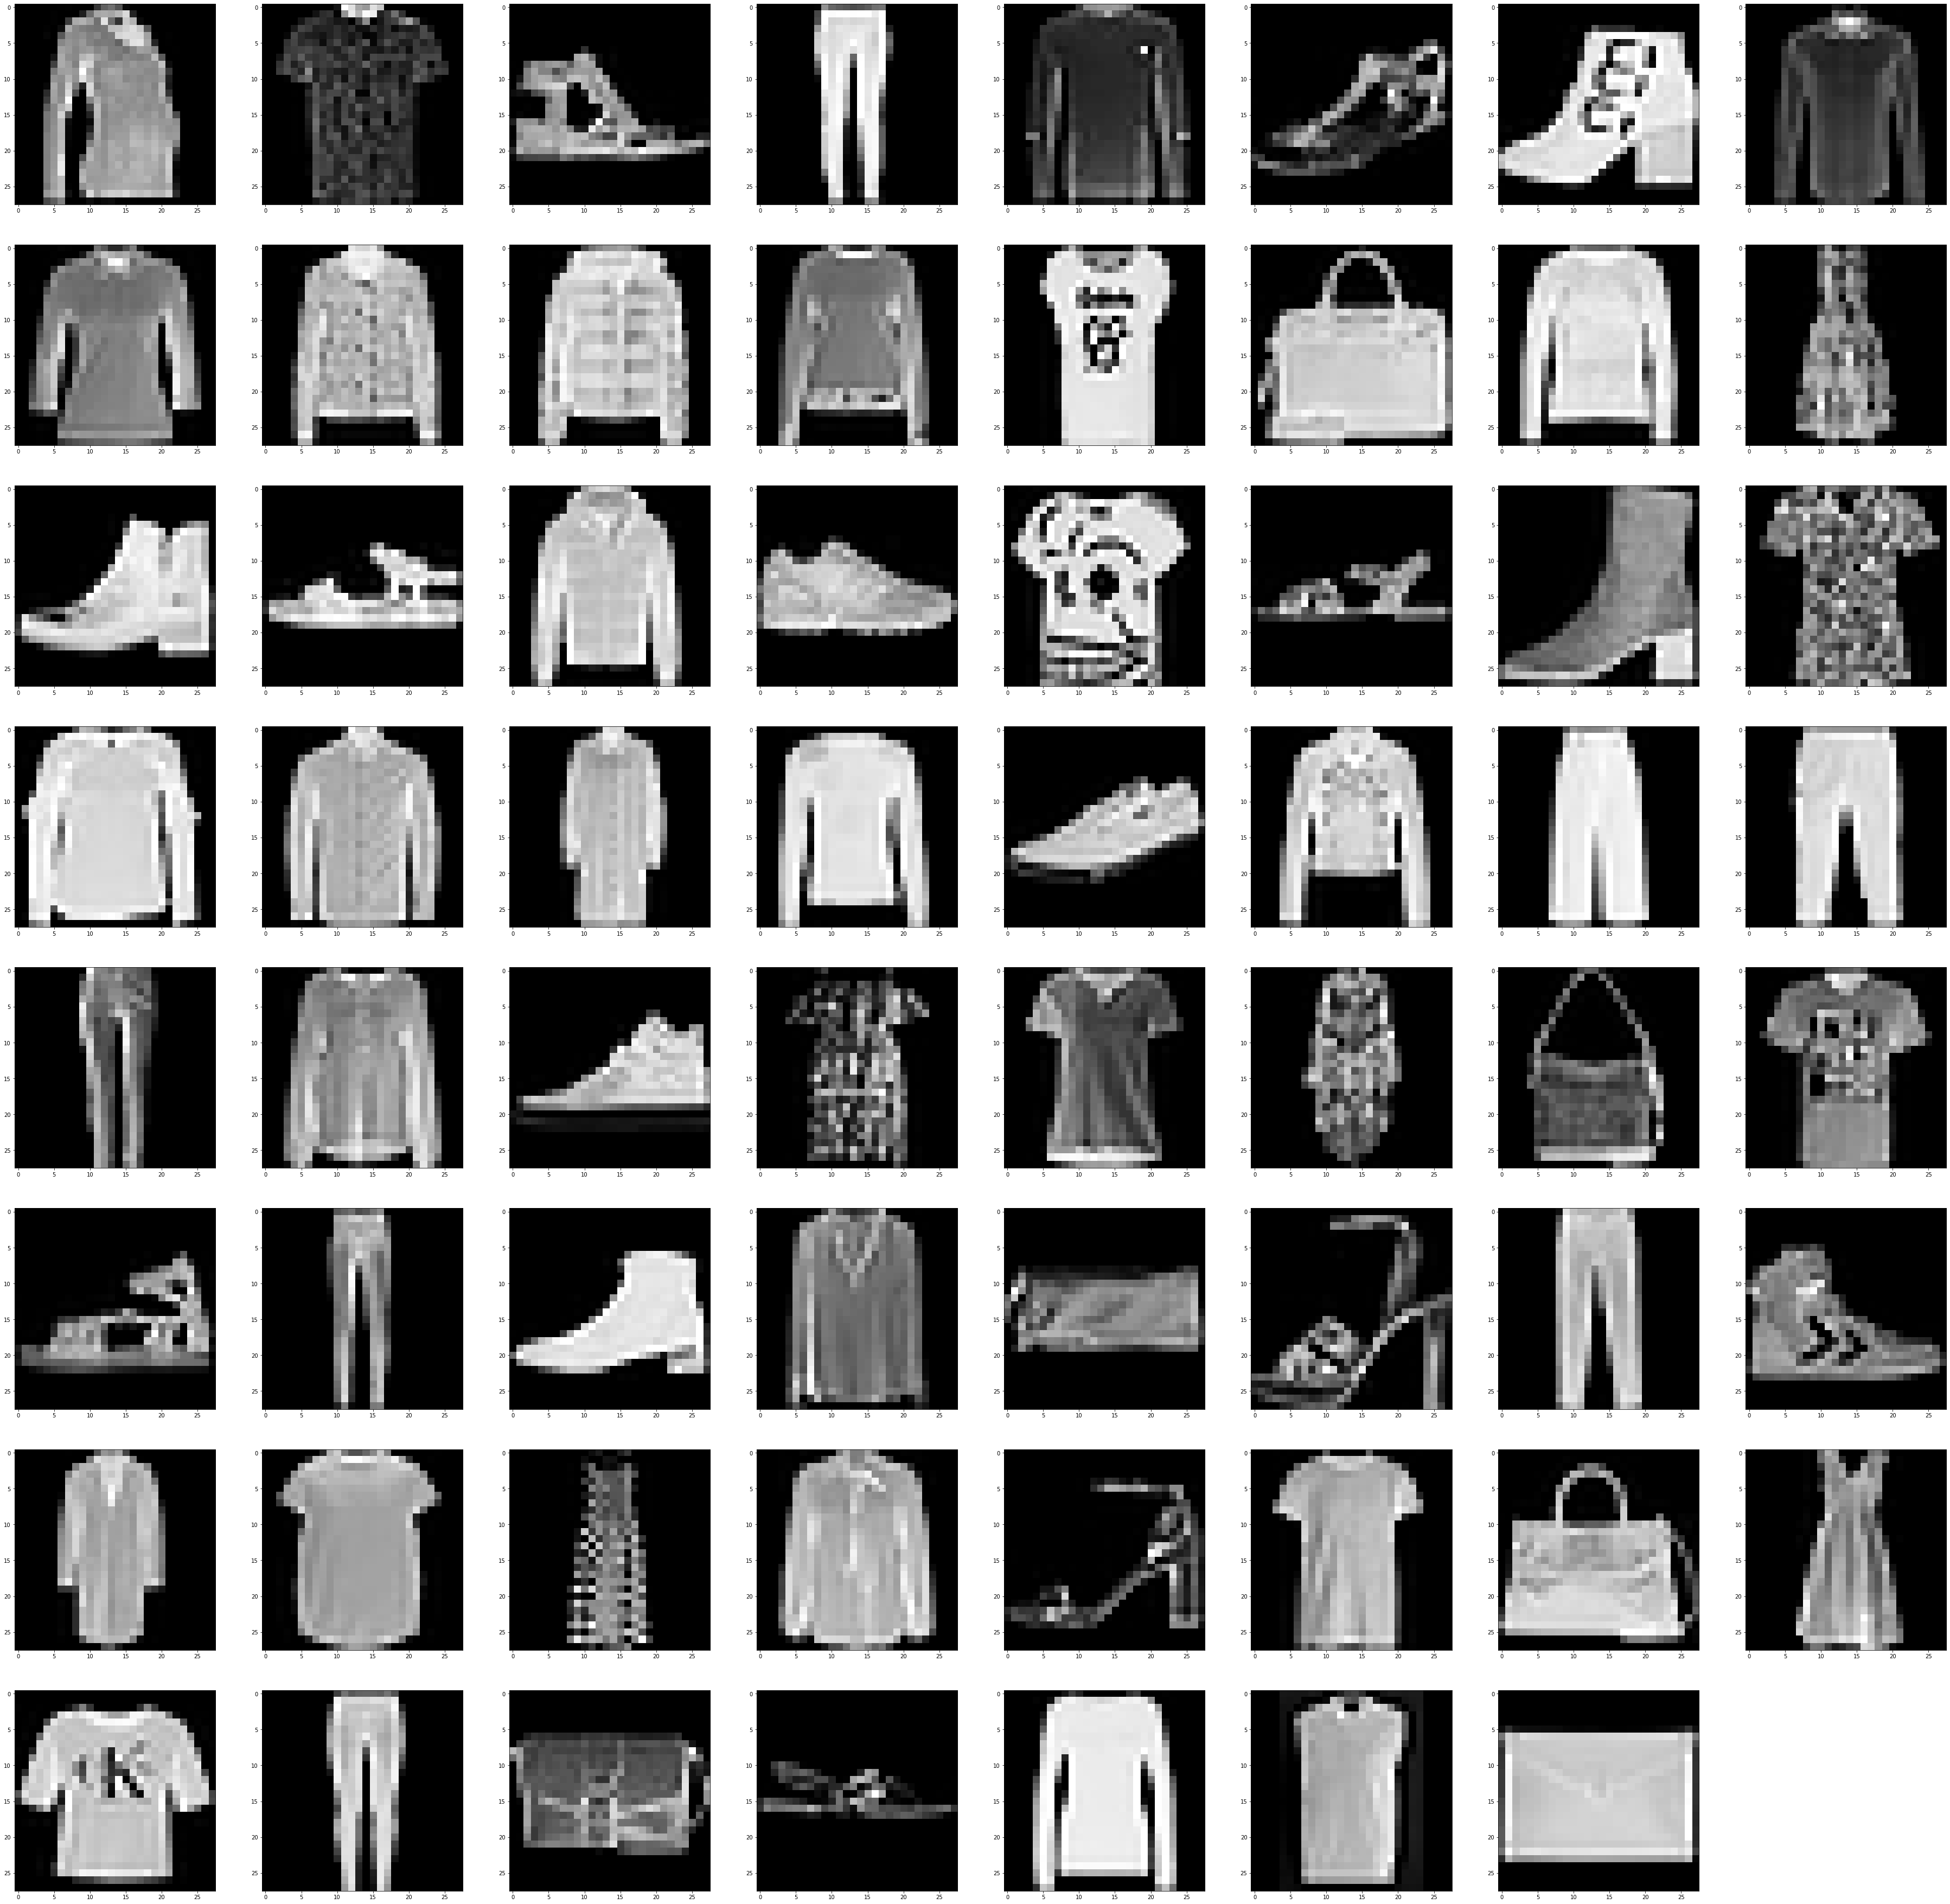

In [0]:
# visualize some training images
vis_X, vis_y = next(iter(train_loader))

plt.figure(figsize=(64, 64))
for i in range(1, batch_size):
  plt.subplot(8, 8, i)
  plt.imshow(vis_X[i-1,0,:,:], cmap='gray')

In [0]:
# define the model structure

# use ResNet-34 as feature extractor
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features

feature_extract = False

def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(model_ft, feature_extract)

model_ft.fc = nn.Linear(num_ftrs, 256)

model_ft = nn.Sequential(
    model_ft,
    nn.Dropout(0.1),
    nn.Linear(256, num_classes))

model_ft = model_ft.to(device)

error = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [0]:
aloss = []
aacc = []

best_model_wts = copy.deepcopy(model_ft.state_dict())
best_accuracy = 0.0

for epoch in range(EPOCHS):
  correct = 0
  running_loss = 0.0

  for batch_idx, (X_, y_) in enumerate(train_loader):
    _vX = Variable(X_).to(device)
    _vy = Variable(y_).to(device)
    optimizer_ft.zero_grad()
    output = model_ft(_vX)
    loss = error(output, _vy)
    loss.backward()
    optimizer_ft.step()

    # Total correct predictions
    predicted = torch.max(output.data, 1)[1] 
    correct += (predicted == _vy).sum()
    running_loss += loss.item() * len(X_)

    #print(correct)
    if batch_idx % 50 == 0:
      print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
        epoch, batch_idx*len(X_), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(batch_size*(batch_idx+1))))

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = correct.double() / len(train_loader.dataset)

  aloss.append(epoch_loss)
  aacc.append(epoch_acc)

  if epoch_acc > best_accuracy:
    best_accuracy = epoch_acc
    best_model_wts = copy.deepcopy(model_ft.state_dict())
  
  scheduler.step()
  
model_ft.load_state_dict(best_model_wts)


Epoch : 0 [0/48000 (0%)]	Loss: 1.668999	 Accuracy:25.000%
Epoch : 0 [3200/48000 (7%)]	Loss: 0.998759	 Accuracy:45.129%
Epoch : 0 [6400/48000 (13%)]	Loss: 0.697857	 Accuracy:57.735%
Epoch : 0 [9600/48000 (20%)]	Loss: 0.713503	 Accuracy:62.645%
Epoch : 0 [12800/48000 (27%)]	Loss: 0.668693	 Accuracy:66.200%
Epoch : 0 [16000/48000 (33%)]	Loss: 0.542770	 Accuracy:68.582%
Epoch : 0 [19200/48000 (40%)]	Loss: 0.682387	 Accuracy:70.157%
Epoch : 0 [22400/48000 (47%)]	Loss: 0.552188	 Accuracy:71.376%
Epoch : 0 [25600/48000 (53%)]	Loss: 0.625373	 Accuracy:72.522%
Epoch : 0 [28800/48000 (60%)]	Loss: 0.444875	 Accuracy:73.514%
Epoch : 0 [32000/48000 (67%)]	Loss: 0.461045	 Accuracy:74.460%
Epoch : 0 [35200/48000 (73%)]	Loss: 0.407273	 Accuracy:74.946%
Epoch : 0 [38400/48000 (80%)]	Loss: 0.301030	 Accuracy:75.491%
Epoch : 0 [41600/48000 (87%)]	Loss: 0.406650	 Accuracy:76.039%
Epoch : 0 [44800/48000 (93%)]	Loss: 0.365927	 Accuracy:76.451%
Epoch : 1 [0/48000 (0%)]	Loss: 0.489107	 Accuracy:76.562%
Epoch 

<All keys matched successfully>

In [0]:
best_accuracy

tensor(0.9524, device='cuda:0', dtype=torch.float64)

In [0]:
torch.save(model_ft.state_dict(), "/content/resnet-101.pth")

In [0]:
vcorrect = 0 
model_ft.eval()
for valid_imgs, valid_labels in valid_loader:
    #print(test_imgs.shape)
    valid_imgs = Variable(valid_imgs).to(device)
    valid_labels = Variable(valid_labels).to(device)
    voutput = model_ft(valid_imgs)
    vpredicted = torch.max(voutput,1)[1]
    vcorrect += (vpredicted == valid_labels).sum()
print("Valid accuracy:{:.3f}% ".format( float(vcorrect)*100 / (len(valid_loader)*batch_size)))


Valid accuracy:90.351% 


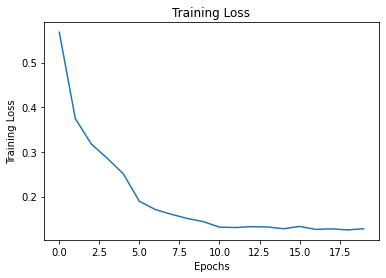

In [0]:
# plot the training loss
plt.plot(range(0, 20), aloss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.savefig('loss-resnet-101.jpg')

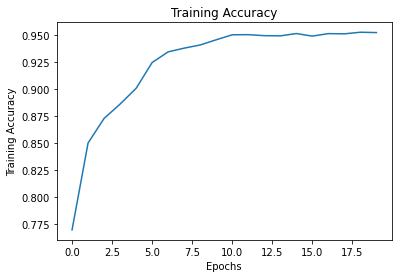

In [0]:
# plot the training accuracy
plt.plot(range(0, 20), aacc)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy")
plt.savefig('accuracy-resnet-101.jpg')

In [0]:
# generate test dataset
# create fake label
test_dst = MNFDataset(arrays=(test, np.zeros(len(test))), transform=_VL_transform)
test_loader = torch.utils.data.DataLoader(test_dst, batch_size=1, shuffle=False)
print(len(test_loader.dataset))
# results
result = np.zeros(len(test_loader.dataset))

model_ft.eval()
for b, (test_imgs, test_labels) in enumerate(test_loader):
    test_imgs = Variable(test_imgs).to(device)
    toutput = model_ft(test_imgs)
    tpredicted = torch.max(toutput,1)[1]
    result[b] = tpredicted.data.cpu().numpy().astype(np.uint8)



10000


In [0]:
result_dict = {}
for i, data in enumerate(result):
  result_dict[i] = np.array([i, data], dtype=np.uint8)

In [0]:
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Id','Label'])

In [0]:
result_df.head()

,Id,Label
0,0,4
1,1,4
2,2,0
3,3,1
4,4,2


In [0]:
result_df.to_csv("/content/resnet_0421_3.csv")

In [0]:
# Create & upload a text file.
# File name which I will export
uploaded = drive.CreateFile({'title': 'resnet_0421_3.csv'})
# Change the name to the previous result.csv
uploaded.SetContentFile('resnet_0421_3.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1PtTqzeZuM2Bw_JEiW_DfZN1B3V7NLgEK
